<a href="https://colab.research.google.com/github/kyw061827/Yewon-KIM/blob/main/GEE_water_storage_mapping_TJK_GRACE%2BXee_Library.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. GRACE(Gravity Recovery and Climate Experiment): 지구 중력장의 변화를 측정하여 지구의 물 저장량 변화를 추적하는 데 사용되는 위성 임무
-> 본 프로젝트에서는 GRACE의 Bands 중 하나인 lwe_thickness (Equivalent liquid water thickness in cm) 이용하여 '물 저장량' 추적함.
2. XEE: Xarray + GEE
3. 물 저장량 변화를 매핑하고 모니터링 => 지하수 고갈, 빙하 녹음, 강수량 변화 등과 같은 현상 연구 가능

In [ ]:
import ee
import geemap
import xarray as xr
!pip install xee
import xee

In [ ]:
ee.Authenticate()
ee.Initialize(
    project = 'gee-waterstorage-tjk',
    opt_url = 'https://earthengine-highvolume.googleapis.com'
)

In [ ]:
map = geemap.Map(basemap = 'SATELLITE')
map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
loc = map.draw_last_feature.geometry()

In [ ]:
loc

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Feature.geometry",
    "arguments": {
      "feature": {
        "functionInvocationValue": {
          "functionName": "Feature",
          "arguments": {
            "geometry": {
              "functionInvocationValue": {
                "functionName": "GeometryConstructors.Point",
                "arguments": {
                  "coordinates": {
                    "constantValue": [
                      71.191224,
                      38.959172
                    ]
                  }
                }
              }
            }
          }
        }
      }
    }
  }
})

In [ ]:
TJK = (
    ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")
    .filterBounds(loc)
    .geometry()
)

map.addLayer(TJK, {}, 'Tajikistan')

In [ ]:
collection = (
    ee.ImageCollection("NASA/GRACE/MASS_GRIDS_V04/MASCON_CRI")
    .filterDate('2003', '2024')
    .select('lwe_thickness')
    .map(lambda img: img.clip(TJK).copyProperties(img, img.propertyNames()))
)

collection

In [ ]:
ds = xr.open_dataset(
    collection,
    engine = 'ee',
    crs = 'EPSG:4326',
    geometry = TJK,
    scale = 1
    #scale=1은 100km를 의미
)

In [ ]:
#Converted ImageCollection into multi-dimensional structure: Data variables인 'lwe_tickness'는 다양한 dimensions (time, lon, lat)로 볼 수 있음.
ds

<xarray.Dataset> Size: 30kB
Dimensions:        (time: 221, lon: 8, lat: 4)
Coordinates:
  * time           (time) datetime64[ns] 2kB 2003-01-31 ... 2023-12-31
  * lon            (lon) float64 64B 67.84 68.84 69.84 ... 72.84 73.84 74.84
  * lat            (lat) float64 32B 37.17 38.17 39.17 40.17
Data variables:
    lwe_thickness  (time, lon, lat) float32 28kB ...
Attributes:
    crs:      EPSG:4326

In [ ]:
ds = ds.sortby('time') * 1

In [ ]:
#Water storage average of each months completed. Now, to see "what the water resource situation is" based on monthly behavior
ds_month = ds.groupby('time.month').mean('time')
ds_month

<xarray.Dataset> Size: 2kB
Dimensions:        (month: 12, lon: 8, lat: 4)
Coordinates:
  * month          (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * lon            (lon) float64 64B 67.84 68.84 69.84 ... 72.84 73.84 74.84
  * lat            (lat) float64 32B 37.17 38.17 39.17 40.17
Data variables:
    lwe_thickness  (month, lon, lat) float32 2kB -1.086 -0.9485 ... nan nan
Attributes:
    crs:      EPSG:4326

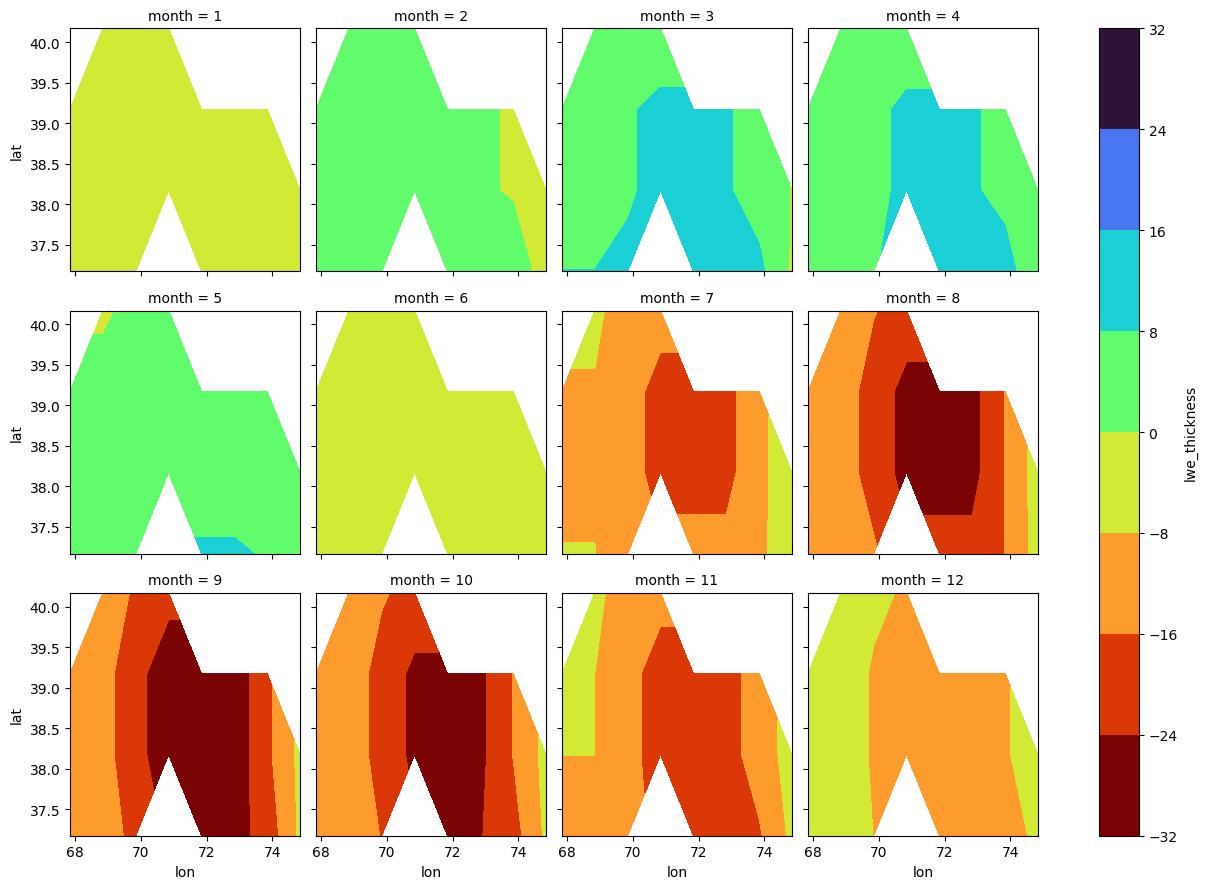

In [ ]:
#Visuatlization: Monthly Water Resource Storage's Dynamic Change
##Blue로 갈수록 positive <-> Red로 갈수록 negative
###결과: 각 region이 얼마나 water를 lose/gain했는지 보여줌.
###해석: 중심부지역에 물부족 현상이 집중되며, 보통 여름~가을 사이에 물 부족이 심각함.

ds_month.lwe_thickness.plot.contourf(
    x = 'lon',
    y = 'lat',
    col = 'month', #temporal dimension
    robust = True, #quality of visualization
    col_wrap = 4, #각 줄(row)에 몇 개의 maps를 넣을 것인지
    cmap = 'turbo_r', #Color palette
    levels = 8 #수치 범주를 더 적거나/많은 level로 나눌 수 있음.
)

#Export Visualization
import matplotlib.pyplot as plt
plt.savefig('water_storage_monthly_TJK.png', dpi = 360, bbox_inches = 'tight')


In [ ]:
#Annual Water Storage
ds_annual = ds.resample(time = 'Y').mean('time')
ds_annual

<xarray.Dataset> Size: 3kB
Dimensions:        (time: 21, lon: 8, lat: 4)
Coordinates:
  * time           (time) datetime64[ns] 168B 2003-12-31 ... 2023-12-31
  * lon            (lon) float64 64B 67.84 68.84 69.84 ... 72.84 73.84 74.84
  * lat            (lat) float64 32B 37.17 38.17 39.17 40.17
Data variables:
    lwe_thickness  (time, lon, lat) float32 3kB -0.421 0.4511 0.4511 ... nan nan
Attributes:
    crs:      EPSG:4326

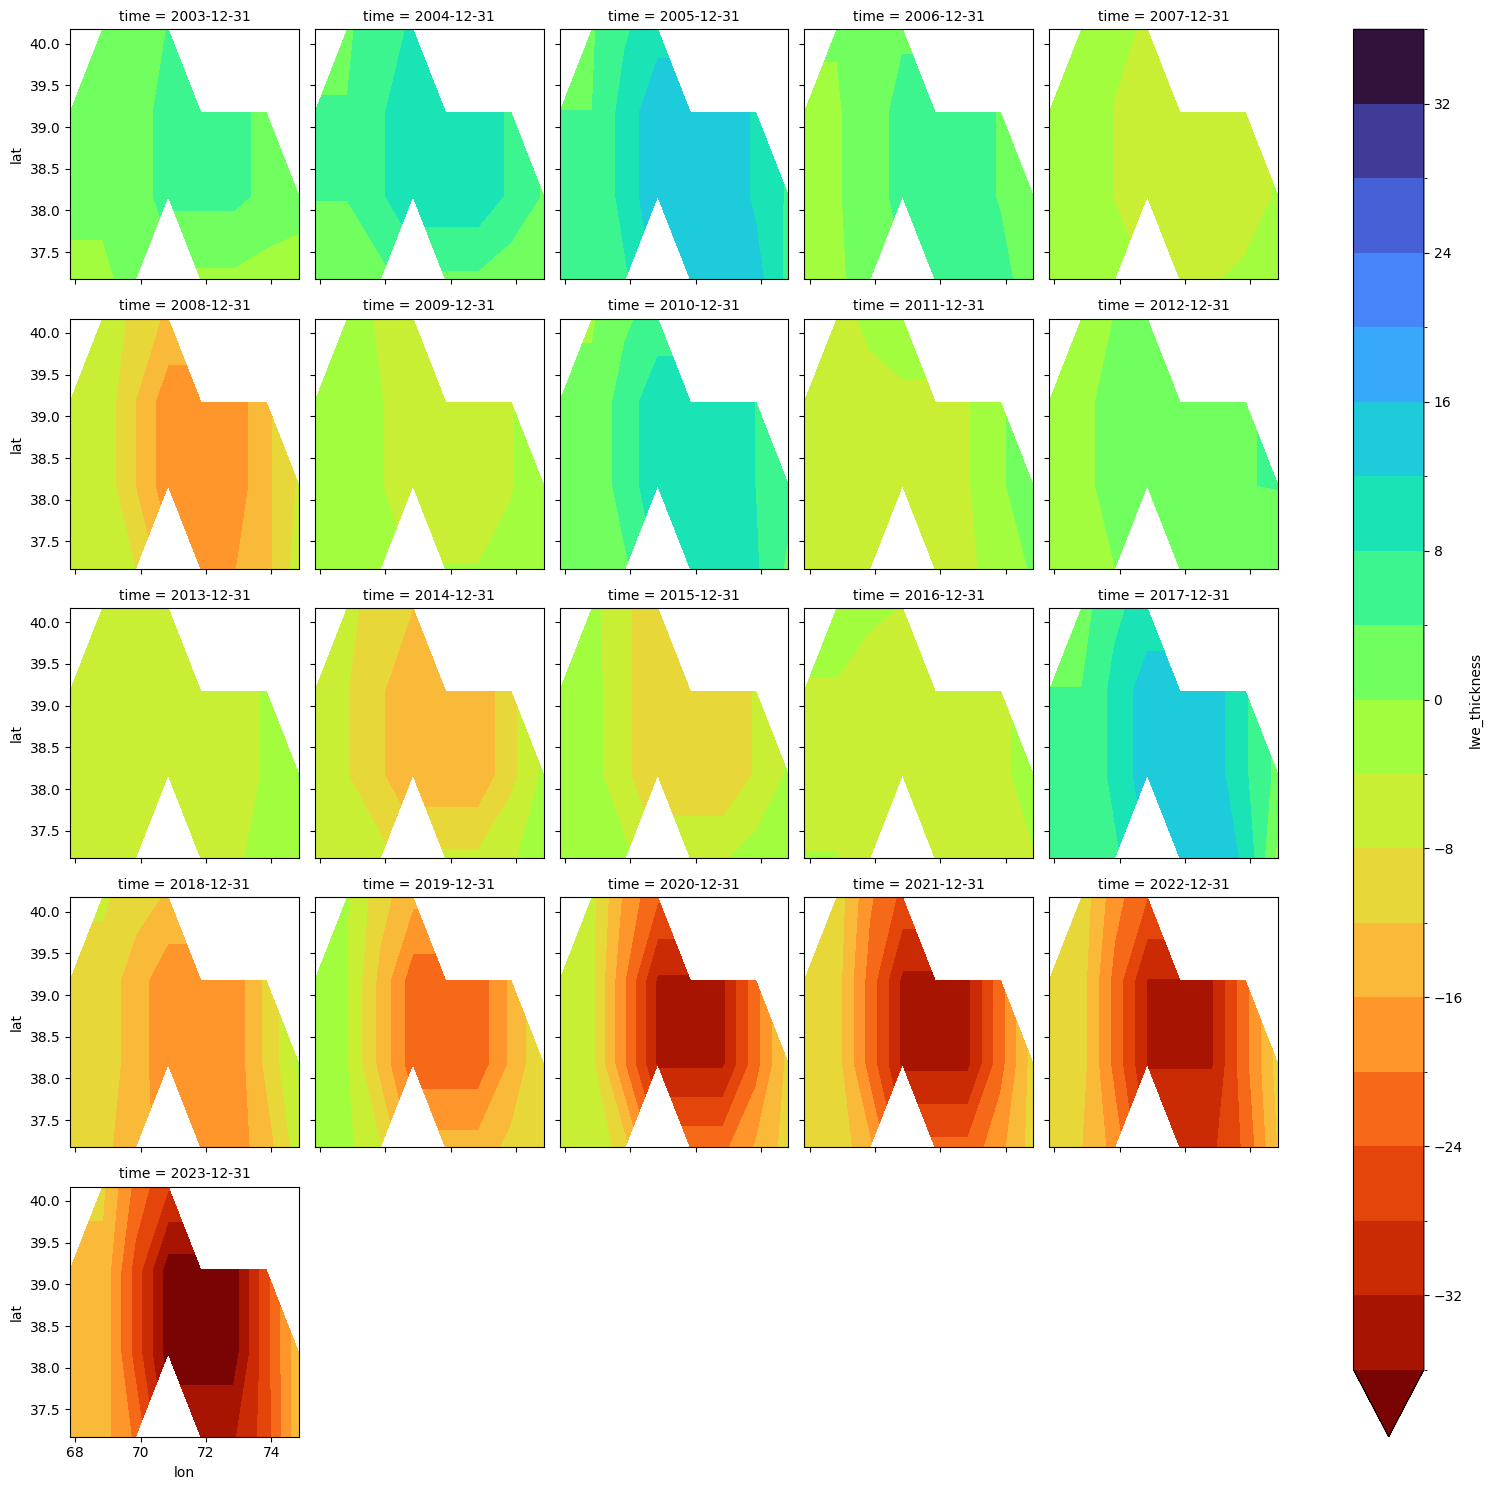

In [ ]:
#Annual dataset에 대한 Visualization
ds_annual.lwe_thickness.plot.contourf(
    x = 'lon',
    y = 'lat',
    col = 'time',
    cmap = 'turbo_r',
    robust = True,
    col_wrap = 5,
    levels = 20
)

#Export Visualization
import matplotlib.pyplot as plt
plt.savefig('water_storage_annual_TJK.png', dpi = 360, bbox_inches = 'tight')

In [ ]:
#Anomaly 의미: 기준값(평균)과 비교했을 때의 차이를 나타내는 편차
#Anomaly = 특정 시점의 물 저장량 − 기준 평균 저장량
##전체 기간동안의 평균 ('ds_annual.mean')을 구하고, 그 평균과 비교해서 water을 얼마나 gain/lose했는지' 보는 것
ds_mean = ds_annual.mean('time')
ds_anomaly = ds_annual - ds_mean

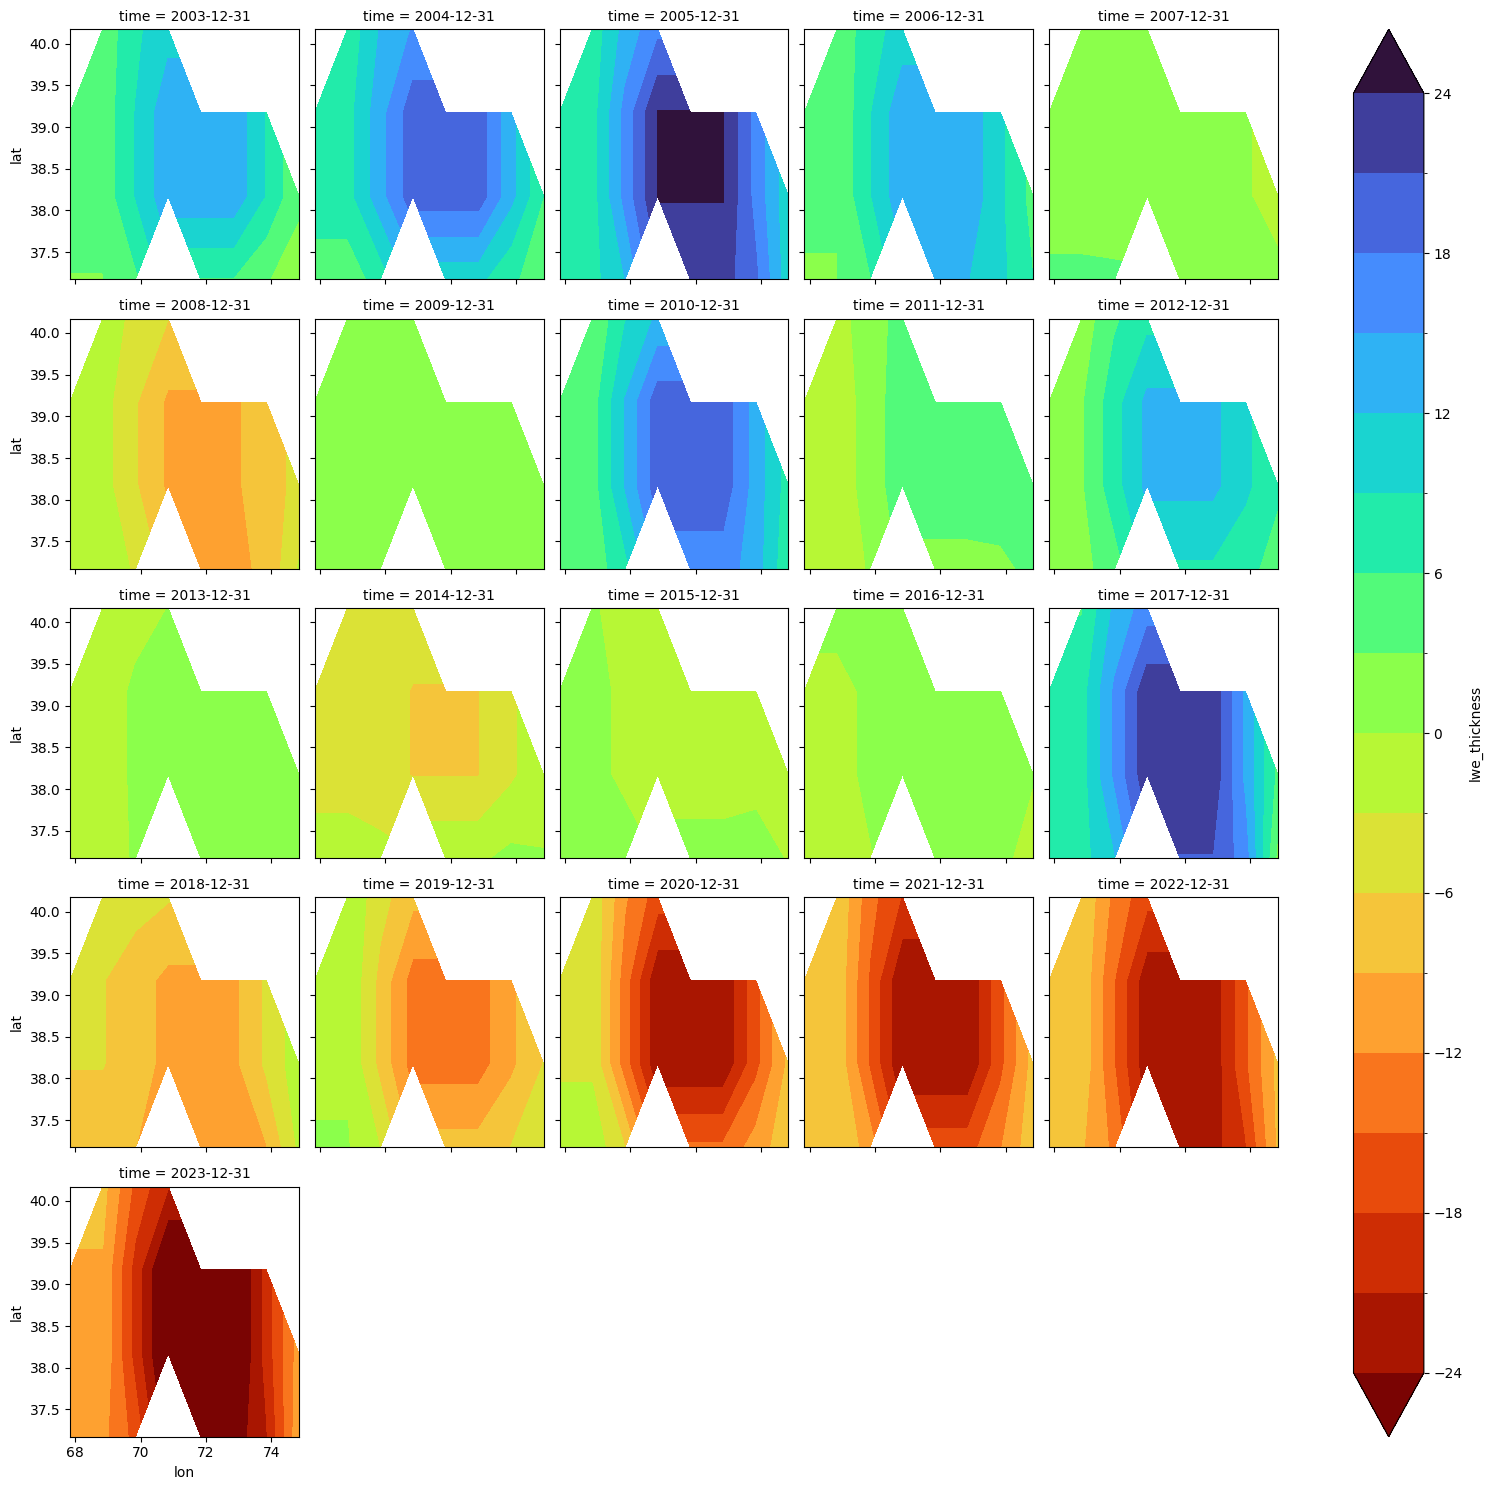

In [ ]:
#Anomaly에 대한 Visualization
#결과해석: 시각화에서 파란 부분일수록 평균보다 많이 물을 gain했음을 의미, 반대로 빨간 부분일수록 평균보다 물을 lose함 의미.
ds_anomaly.lwe_thickness.plot.contourf(
    x = 'lon',
    y = 'lat',
    col = 'time',
    cmap = 'turbo_r',
    col_wrap = 5,
    robust = True,
    levels = 20
)

#Export
import matplotlib.pyplot as plt
plt.savefig('water_storage_anomaly_TJK.png', dpi = 360, bbox_inches = 'tight')